In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import textwrap
from sklearn.cluster import SpectralClustering

In [2]:
import psycopg2
from psycopg2 import sql
from psycopg2.extensions import adapt, register_adapter, AsIs
from sqlalchemy import create_engine
import getpass

In [ ]:
database = 'f24t03'
user = 'jsmm8'
password = getpass.getpass("Type password and hit enter: ")

Type password and hit enter: ········


In [ ]:
try:
    # Connect to the PostgreSQL database
    connection = psycopg2.connect(dbname=database, user=user, password=password, host='pgsql')
    cursor = connection.cursor()

    # Execute a query to get all table names
    cursor.execute("""
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'public';
    """)
    
    # Fetch all results
    tables = cursor.fetchall()

    # Print the table names
    print("Tables in the database:")
    for table in tables:
        print(table[0])

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()

Tables in the database:
ethnicity
year_built
education_levels
tenure_by_bedrooms
tenure_by_kitchen
tenure_by_plumbing
education_data_processed
rooms
demographics_master
education_categories
year_structure_built
race_data_processed
tenure_by_rooms
housing_stats_data
bedrooms
educational_attainment
employment_status
geo_mobility
home_value
house_heating_fuel
race_migration_data
household_income
internet_subscription
income_to_poverty_ratio
median_home_value
median_household_income
median_rooms_by_tenure
occupancy_status
plumbing_facilities
poverty_status
mortgage_status
housing_pct_change_stats_data
income_pct_change
income_data_processed


In [ ]:
#Create the connection and extract data from 'median_home_value' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=password)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the median_home_value table
query = "SELECT * FROM median_home_value where year in (2020,2021,2022);"

# Use pandas to read the SQL query into a DataFrame
try:
    df = pd.read_sql(query, conn)
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()


# Display the DataFrame
df.shape

I am able to connect to the database
Data extracted successfully!


(15093, 8)

In [6]:
df.head()

,geo_id,block_group,census_tract,county,state,est_median_value,total_margin_of_error,year
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,142300.0,21569.0,2020
1,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,148300.0,24676.0,2020
2,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,86100.0,13432.0,2020
3,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,75300.0,30542.0,2020
4,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,92300.0,28802.0,2020


In [7]:
# Drop the identified columns
df_cleaned = df.drop('total_margin_of_error',axis = 1)
df_cleaned.rename(columns={'est_median_value': 'median_value'}, inplace=True)

# Display the cleaned DataFrame
print("\nCleaned DataFrame:")
df_cleaned.head(1)


Cleaned DataFrame:


,geo_id,block_group,census_tract,county,state,median_value,year
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,142300.0,2020


In [8]:
df_cleaned['median_value'].describe()

count    1.401500e+04
mean     1.806651e+05
std      1.166976e+05
min      1.000000e+04
25%      1.062000e+05
50%      1.570000e+05
75%      2.217000e+05
max      1.737900e+06
Name: median_value, dtype: float64

In [9]:
df_cleaned['median_value'].describe()

count    1.401500e+04
mean     1.806651e+05
std      1.166976e+05
min      1.000000e+04
25%      1.062000e+05
50%      1.570000e+05
75%      2.217000e+05
max      1.737900e+06
Name: median_value, dtype: float64

In [10]:
df_cleaned['median_value'] = df_cleaned['median_value'].astype(float)

In [11]:
df_cleaned['median_value'].describe()

count    1.401500e+04
mean     1.806651e+05
std      1.166976e+05
min      1.000000e+04
25%      1.062000e+05
50%      1.570000e+05
75%      2.217000e+05
max      1.737900e+06
Name: median_value, dtype: float64

In [12]:
df_cleaned[df_cleaned['median_value'].isnull()].groupby('year').size()

year
2020    360
2021    363
2022    355
dtype: int64

In [13]:
df_cleaned[df_cleaned['year']==2022].head()

,geo_id,block_group,census_tract,county,state,median_value,year
10062,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,178900.0,2022
10063,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,167100.0,2022
10064,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,94700.0,2022
10065,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,89300.0,2022
10066,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,157600.0,2022


In [14]:
df_cleaned['median_value'] = pd.to_numeric(df_cleaned['median_value'], errors='raise')

In [15]:
year_column_name = 'year'
years = df_cleaned[year_column_name].unique()

for year in years:
    print(f"Descriptive statistics for {year}:")
    print(df_cleaned[df_cleaned[year_column_name] == year].describe())
    print("\n")

Descriptive statistics for 2020:
       median_value    year
count  4.671000e+03  5031.0
mean   1.666855e+05  2020.0
std    1.078728e+05     0.0
min    1.000000e+04  2020.0
25%    9.760000e+04  2020.0
50%    1.453000e+05  2020.0
75%    2.014500e+05  2020.0
max    1.737900e+06  2020.0


Descriptive statistics for 2021:
       median_value    year
count  4.668000e+03  5031.0
mean   1.750445e+05  2021.0
std    1.122291e+05     0.0
min    1.000000e+04  2021.0
25%    1.036000e+05  2021.0
50%    1.526500e+05  2021.0
75%    2.151500e+05  2021.0
max    1.678300e+06  2021.0


Descriptive statistics for 2022:
       median_value    year
count  4.676000e+03  5031.0
mean   2.002407e+05  2022.0
std    1.265502e+05     0.0
min    1.000000e+04  2022.0
25%    1.189750e+05  2022.0
50%    1.723500e+05  2022.0
75%    2.455250e+05  2022.0
max    1.601000e+06  2022.0




<Figure size 1728x864 with 0 Axes>

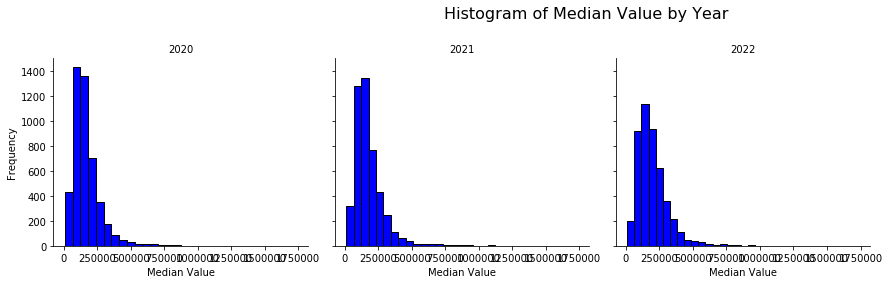

In [16]:
plt.figure(figsize=(24, 12))
g = sns.FacetGrid(df_cleaned, col='year', col_wrap=4, height=4)
g.map(plt.hist, 'median_value', bins=30, color='blue', edgecolor='black')

# Set titles and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Median Value', 'Frequency')
g.fig.suptitle('Histogram of Median Value by Year', fontsize=16)
g.fig.subplots_adjust(top=0.8)

plt.show()

In [17]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15093 entries, 0 to 15092
Data columns (total 7 columns):
geo_id          15093 non-null object
block_group     15093 non-null object
census_tract    15093 non-null object
county          15093 non-null object
state           15093 non-null object
median_value    14015 non-null float64
year            15093 non-null int64
dtypes: float64(1), int64(1), object(5)
memory usage: 825.5+ KB


In [18]:
df_cleaned[df_cleaned['median_value'].isnull()].groupby('year').size()

year
2020    360
2021    363
2022    355
dtype: int64

In [19]:
pivot_table = df_cleaned.pivot_table(index='geo_id', columns='year', values='median_value', aggfunc=lambda x: x.isnull().sum(), fill_value=0)

# Count the number of missing values (nulls) across the years for each geography
pivot_table['Missing Values Count'] = (pivot_table > 0).sum(axis=1)

# Filter geographies based on the number of missing values
counts = pivot_table['Missing Values Count'].value_counts().reset_index()
counts.columns = ['Number of Missing Years', 'Geography Count']

print(counts)

   Number of Missing Years  Geography Count
0                        0             4472
1                        1              241
2                        3              201
3                        2              117


In [20]:
df_race_ethnic_data = pd.read_csv('race_ethnicity_combination_with_dominant_race.csv')
df_race_ethnic_data.head()

,geo_id,Total_Population,Shannon_Index,Simpsons_Index,Richness,Simpson_Dominance,Berger_Parker_Dominance,Simpson_Evenness,Year,block_group,...,state,Dominant_Race,native,asian,black,Hispanic or Latino,pac_isl,other,white,two or more races
0,1500000US290019501001,1121,0.08,0.04,0.50,0.96,0.98,0.06,2022,Block Group 1,...,Missouri,white,0.0,0.00,0.0,0.00,0.00,0.01,1.00,0.01
1,1500000US290019501002,1589,0.06,0.03,0.38,0.97,0.98,0.05,2022,Block Group 2,...,Missouri,white,0.0,0.00,0.0,0.00,0.00,0.00,1.00,0.01
2,1500000US290019501003,961,0.29,0.24,0.62,0.76,0.86,0.31,2022,Block Group 3,...,Missouri,white,0.0,0.00,0.0,0.15,0.00,0.00,0.99,0.00
3,1500000US290019502001,1031,0.30,0.20,0.62,0.80,0.89,0.25,2022,Block Group 1,...,Missouri,white,0.0,0.01,0.0,0.06,0.01,0.00,1.00,0.03
4,1500000US290019502002,998,0.06,0.04,0.25,0.96,0.98,0.07,2022,Block Group 2,...,Missouri,white,0.0,0.00,0.0,0.00,0.00,0.00,1.00,0.02


In [21]:
df_zero_population = df_race_ethnic_data[df_race_ethnic_data['Total_Population'] == 0]
yearwise_count = df_zero_population.groupby('Year').size().reset_index(name='Count')

print(yearwise_count)

   Year  Count
0  2018      7
1  2019      7
2  2020     17
3  2021     18
4  2022     19


In [22]:
# Filter DataFrames for each year
df_2020 = df_zero_population[df_zero_population['Year'] == 2020]
df_2021 = df_zero_population[df_zero_population['Year'] == 2021]
df_2022 = df_zero_population[df_zero_population['Year'] == 2022]
df_2018 = df_zero_population[df_zero_population['Year'] == 2018]
df_2019 = df_zero_population[df_zero_population['Year'] == 2019]

# Find common geographies across the three years
common_geographies = set(df_2020['geo_id']).intersection(df_2021['geo_id'], df_2022['geo_id'], df_2018['geo_id'], df_2019['geo_id'])

# Extract counts for common geographies
common_counts = df_zero_population[df_zero_population['geo_id'].isin(common_geographies)]

# Group by Geography and Year to get counts
final_counts = common_counts.groupby(['geo_id', 'Year']).size().reset_index(name='Count')

In [23]:
median_value_per_year = df_cleaned.groupby('year')['median_value'].median().reset_index()
median_value_per_year.columns = ['year', 'Median Value']

# Step 1: Identify geographies with missing values in all three years
geographies_with_3_missing = pivot_table[pivot_table['Missing Values Count'] == 3].index

# Step 2: Get the geographies from df_zero_population
geographies_zero_population = common_geographies

# Step 3: Update median_value for those geographies where it is missing
for geo in geographies_with_3_missing:
    for year in df_cleaned['year'].unique():
        if geo in geographies_zero_population:
            df_cleaned.loc[(df_cleaned['geo_id'] == geo) & (df_cleaned['year'] == year), 'median_value'] = 0

In [24]:
df_cleaned[df_cleaned['median_value'].isnull()].groupby('year').size()

year
2020    356
2021    359
2022    351
dtype: int64

In [ ]:
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=password)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

query = "SELECT * FROM occupancy_status where year in (2020,2021,2022);"

# Use pandas to read the SQL query into a DataFrame
try:
    merged_housing_data = pd.read_sql(query, conn)
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()

# Display the DataFrame
merged_housing_data.shape

I am able to connect to the database
Data extracted successfully!


(15093, 12)

In [26]:
# Display the merged DataFrame
merged_housing_data.head()

,geo_id,block_group,census_tract,county,state,total_estimate,total_margin_of_error,est_total_occupied,moe_total_occupied,est_total_vacant,margin_of_error_total_vacant,year
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,581,86,448,79,133,69,2020
1,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,607,86,516,91,91,47,2020
2,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,499,70,338,58,161,47,2020
3,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,421,71,315,57,106,52,2020
4,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,547,92,377,79,170,48,2020


In [27]:
# Find columns with 'Error' in their names
columns_to_drop = ['total_margin_of_error','moe_total_occupied','margin_of_error_total_vacant']

# Drop the identified columns
merged_housing_data = merged_housing_data.drop(columns=columns_to_drop)

# Display the cleaned DataFrame
print("\nCleaned DataFrame:")
merged_housing_data.head(1)


Cleaned DataFrame:


,geo_id,block_group,census_tract,county,state,total_estimate,est_total_occupied,est_total_vacant,year
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,581,448,133,2020


In [28]:
# Filter DataFrames for each year based on 'Total' column
df_housing_2020 = merged_housing_data[(merged_housing_data['total_estimate'] == 0) & (merged_housing_data['year'] == 2020)]
df_housing_2021 = merged_housing_data[(merged_housing_data['total_estimate'] == 0) & (merged_housing_data['year'] == 2021)]
df_housing_2022 = merged_housing_data[(merged_housing_data['total_estimate'] == 0) & (merged_housing_data['year'] == 2022)]
df_housing_2018 = merged_housing_data[(merged_housing_data['total_estimate'] == 0) & (merged_housing_data['year'] == 2018)]
df_housing_2019 = merged_housing_data[(merged_housing_data['total_estimate'] == 0) & (merged_housing_data['year'] == 2019)]

# Find common geographies across the three years
common_geographies = set(df_housing_2020['geo_id']).intersection(df_housing_2021['geo_id'], df_housing_2022['geo_id'], df_housing_2018['geo_id'], df_housing_2019['geo_id'])

# Extract counts for common geographies
common_counts = pd.concat([
    df_housing_2020[df_housing_2020['geo_id'].isin(common_geographies)],
    df_housing_2021[df_housing_2021['geo_id'].isin(common_geographies)],
    df_housing_2022[df_housing_2022['geo_id'].isin(common_geographies)],
    df_housing_2018[df_housing_2018['geo_id'].isin(common_geographies)],
    df_housing_2019[df_housing_2019['geo_id'].isin(common_geographies)]
])

# Group by Geography and Year to get counts
final_counts = common_counts.groupby(['geo_id']).size().reset_index(name='Count')

In [29]:
geographies_with_3_missing = pivot_table[pivot_table['Missing Values Count'] == 3].index

# Step 2: Get the geographies from df_zero_population
geographies_zero_housing = common_geographies

## Step 3: Update median_value for those geographies where it is missing
for geo in geographies_with_3_missing:
    for year in df_cleaned['year'].unique():
        if geo in geographies_zero_housing:
            # Set median_value to 0 for the identified geography and year
            df_cleaned.loc[(df_cleaned['geo_id'] == geo) & (df_cleaned['year'] == year), 'median_value'] = 0

In [30]:
df_cleaned[df_cleaned['median_value'].isnull()].groupby('year').size()

year
2020    356
2021    359
2022    351
dtype: int64

In [31]:
# Filter for rows with NULL or empty values
null_value_df = df_cleaned[df_cleaned['median_value'].isnull() | 
                              (df_cleaned['median_value'] == '')]

# Select the relevant columns
df_missing = null_value_df[['geo_id', 'median_value', 'year']]

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [32]:
# Filter rows where 'median_value' is either NULL or 0
missing_or_zero = df_cleaned[(df_cleaned['median_value'].isnull())]

# Group by 'year' and count the occurrences
yearwise_count = missing_or_zero.groupby('year').size().reset_index(name='Count')

# Display the year-wise count
print("Year-wise Count of (geo_id, year) Combinations with NULL or 0 Median Value:\n")
print(yearwise_count)

Year-wise Count of (geo_id, year) Combinations with NULL or 0 Median Value:

   year  Count
0  2020    356
1  2021    359
2  2022    351


In [ ]:
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=password)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

query = "SELECT * FROM home_value where year in (2020,2021,2022);"

# Use pandas to read the SQL query into a DataFrame
try:
    df2 = pd.read_sql(query, conn)
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()

# Display the DataFrame
df2.shape

I am able to connect to the database
Data extracted successfully!


(15093, 60)

In [34]:
df2.head()

,geo_id,block_group,census_tract,counties,state,estimate_total,margin_of_error_total,estimate_total_less_than_10000,margin_of_error_total_less_than_10000,estimate_total_10000_to_14999,...,margin_of_error_total_500000_to_749999,estimate_total_750000_to_999999,margin_of_error_total_750000_to_999999,estimate_total_1000000_to_1499999,margin_of_error_total_1000000_to_1499999,estimate_total_1500000_to_1999999,margin_of_error_total_1500000_to_1999999,estimate_total_2000000_or_more,margin_of_error_total_2000000_or_more,year
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,435,79,0,12,0,...,6,0,12,0,12,0,12,0,12,2020
1,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,453,84,10,14,6,...,16,0,12,0,12,0,12,0,12,2020
2,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,303,58,5,8,5,...,6,0,12,0,12,0,12,0,12,2020
3,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,259,55,39,28,8,...,12,0,12,0,12,0,12,0,12,2020
4,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,332,76,7,11,0,...,4,0,12,0,12,3,5,3,4,2020


In [35]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15093 entries, 0 to 15092
Data columns (total 60 columns):
geo_id                                      15093 non-null object
block_group                                 15093 non-null object
census_tract                                15093 non-null object
counties                                    15093 non-null object
state                                       15093 non-null object
estimate_total                              15093 non-null int64
margin_of_error_total                       15093 non-null int64
estimate_total_less_than_10000              15093 non-null int64
margin_of_error_total_less_than_10000       15093 non-null int64
estimate_total_10000_to_14999               15093 non-null int64
margin_of_error_total_10000_to_14999        15093 non-null int64
estimate_total_15000_to_19999               15093 non-null int64
margin_of_error_total_15000_to_19999        15093 non-null int64
estimate_total_20000_to_24999            

In [36]:
import numpy as np

price_brackets = {
    'estimate_total_less_than_10000': (0, 9999),
    'estimate_total_10000_to_14999': (10000, 14999),
    'estimate_total_15000_to_19999': (15000, 19999),
    'estimate_total_20000_to_24999': (20000, 24999),
    'estimate_total_25000_to_29999': (25000, 29999),
    'estimate_total_30000_to_34999': (30000, 34999),
    'estimate_total_35000_to_39999': (35000, 39999),
    'estimate_total_40000_to_49999': (40000, 49999),
    'estimate_total_50000_to_59999': (50000, 59999),
    'estimate_total_60000_to_69999': (60000, 69999),
    'estimate_total_70000_to_79999': (70000, 79999),
    'estimate_total_80000_to_89999': (80000, 89999),
    'estimate_total_90000_to_99999': (90000, 99999),
    'estimate_total_100000_to_124999': (100000, 124999),
    'estimate_total_125000_to_149999': (125000, 149999),
    'estimate_total_150000_to_174999': (150000, 174999),
    'estimate_total_175000_to_199999': (175000, 199999),
    'estimate_total_200000_to_249999': (200000, 249999),
    'estimate_total_250000_to_299999': (250000, 299999),
    'estimate_total_300000_to_399999': (300000, 399999),
    'estimate_total_400000_to_499999': (400000, 499999),
    'estimate_total_500000_to_749999': (500000, 749999),
    'estimate_total_750000_to_999999': (750000, 999999),
    'estimate_total_1000000_to_1499999': (1000000, 1499999),
    'estimate_total_1500000_to_1999999': (1500000, 1999999),
    'estimate_total_2000000_or_more': (2000000, 3000000)
}


# Initialize a list to store results
all_results = []
np.random.seed(0)
# Iterate over rows in df
for index, row in df2.iterrows():
    # Extract the year from the row
    year = row['year']
    
    
    # Generate synthetic median value records for each geography
    synthetic_records = []
    
    for col, (min_value, max_value) in price_brackets.items():
        num_samples = row[col]
        
        if num_samples > 0:  # Only generate samples if there are estimates
            samples = np.random.randint(
                min_value, 
                max_value + 1, 
                size=num_samples
            ) 
            synthetic_records.extend(samples)
    
    # Calculate the median for the current geography
    median_value = np.median(synthetic_records) if synthetic_records else None
    
    # Store the geography, median value, and year
    all_results.append({
        'geo_id': row['geo_id'],
        'Median Value': median_value,
        'year': year
    })

# Create a DataFrame for all results
results_df = pd.DataFrame(all_results)

# Check for zero or null values in the 'Median Value' column
zero_values = results_df[results_df['Median Value'] == 0]
null_values = results_df[results_df['Median Value'].isnull()]

results_df['Median Value'] = results_df['Median Value'].round(0)
results_df.head()

,geo_id,Median Value,year
0,1500000US290019501001,142191.0,2020
1,1500000US290019501002,149122.0,2020
2,1500000US290019501003,84850.0,2020
3,1500000US290019502001,74212.0,2020
4,1500000US290019502002,94402.0,2020


In [37]:
# Filter rows where 'median_value' is either NULL or 0
missing_or_zero = results_df[(results_df['Median Value'].isnull()) | (results_df['Median Value'] == 0)]

# Group by 'year' and count the occurrences
yearwise_count = missing_or_zero.groupby('year').size().reset_index(name='Count')

# Display the year-wise count
print("Year-wise Count of (geo_id, year) Combinations with NULL or 0 Median Value:\n")
print(yearwise_count)


Year-wise Count of (geo_id, year) Combinations with NULL or 0 Median Value:

   year  Count
0  2020     78
1  2021     84
2  2022     83


In [38]:
# Merge 'df_cleaned' with 'results_df' on 'geo_id' and 'year' to fetch 'Median Value'
df_filled = df_cleaned.merge(
    results_df[['geo_id', 'year', 'Median Value']],
    on=['geo_id', 'year'],
    how='left'
)

# Impute NULL values in 'median_value' with corresponding 'Median Value' from 'results_df'
df_filled['median_value'] = df_filled['median_value'].fillna(df_filled['Median Value'])

# Drop the temporary 'Median Value' column as it's no longer needed
df_filled = df_filled.drop(columns=['Median Value'])

# Display the updated DataFrame (optional)
print("\nData after Imputation:\n")
df_filled.head()


Data after Imputation:



,geo_id,block_group,census_tract,county,state,median_value,year
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,142300.0,2020
1,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,148300.0,2020
2,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,86100.0,2020
3,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,75300.0,2020
4,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,92300.0,2020


In [39]:
df_filled.shape

(15093, 7)

In [40]:
df_filled[df_filled['median_value'].isnull()].groupby('year').size()

year
2020    74
2021    80
2022    79
dtype: int64

In [41]:
pivot_table = df_filled.pivot_table(index='geo_id', columns='year', values='median_value', aggfunc=lambda x: x.isnull().sum(), fill_value=0)

# Count the number of missing values (nulls) across the years for each geography
pivot_table['Missing Values Count'] = (pivot_table > 0).sum(axis=1)

# Filter geographies based on the number of missing values
counts = pivot_table['Missing Values Count'].value_counts().reset_index()
counts.columns = ['Number of Missing Years', 'Geography Count']

print(counts)

   Number of Missing Years  Geography Count
0                        0             4939
1                        3               64
2                        1               15
3                        2               13


In [42]:
# Create a pivot table to inspect missing values across years for each geo_id
pivot_table = df_filled.pivot_table(
    index='geo_id', columns='year', values='median_value', 
    aggfunc=lambda x: x.isnull().sum(), fill_value=0
)

# Count the number of missing values across years for each geography
pivot_table['Missing Values Count'] = (pivot_table > 0).sum(axis=1)

# Filter geographies with missing values (i.e., Missing Values Count > 0)
geos_with_missing = pivot_table[pivot_table['Missing Values Count'] > 0].reset_index()

print("Geographies with Remaining Missing Values:\n")
print(geos_with_missing)

# Display specific (geo_id, year) combinations with NULL median_value
remaining_nulls = df_filled[df_filled['median_value'].isnull()]
print("\nSpecific (geo_id, year) Combinations with NULL median_value:\n")
print(remaining_nulls[['geo_id', 'year', 'median_value']])

# Fill the remaining NULL median_value values with 0
df_filled['median_value'] = df_filled['median_value'].fillna(0)

# Verify that there are no more NULL values
remaining_nulls_after = df_filled[df_filled['median_value'].isnull()]

print("\nRemaining NULL Values After Filling with 0 (should be empty):\n")
print(remaining_nulls_after)


Geographies with Remaining Missing Values:

year                 geo_id  2020  2021  2022  Missing Values Count
0     1500000US290019509003     1     1     1                     3
1     1500000US290019510001     1     0     0                     1
2     1500000US290190005001     1     1     1                     3
3     1500000US290190005003     1     1     1                     3
4     1500000US290190010011     0     0     1                     1
..                      ...   ...   ...   ...                   ...
87    1500000US292017812013     1     0     0                     1
88    1500000US295101193001     0     1     1                     2
89    1500000US295101193003     0     1     1                     2
90    1500000US295101212001     1     1     1                     3
91    1500000US295101278002     1     1     1                     3

[92 rows x 5 columns]

Specific (geo_id, year) Combinations with NULL median_value:

                      geo_id  year  median_value
21   

In [43]:
pivot_table = df_filled.pivot_table(index='geo_id', columns='year', values='median_value', aggfunc=lambda x: x.isnull().sum(), fill_value=0)

# Count the number of missing values (nulls) across the years for each geography
pivot_table['Missing Values Count'] = (pivot_table > 0).sum(axis=1)

# Filter geographies based on the number of missing values
counts = pivot_table['Missing Values Count'].value_counts().reset_index()
counts.columns = ['Number of Missing Years', 'Geography Count']

print(counts)

   Number of Missing Years  Geography Count
0                        0             5031


In [44]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15093 entries, 0 to 15092
Data columns (total 7 columns):
geo_id          15093 non-null object
block_group     15093 non-null object
census_tract    15093 non-null object
county          15093 non-null object
state           15093 non-null object
median_value    15093 non-null float64
year            15093 non-null int64
dtypes: float64(1), int64(1), object(5)
memory usage: 943.3+ KB


In [59]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15093 entries, 0 to 15092
Data columns (total 7 columns):
geo_id          15093 non-null object
block_group     15093 non-null object
census_tract    15093 non-null object
county          15093 non-null object
state           15093 non-null object
median_value    15093 non-null float64
year            15093 non-null int64
dtypes: float64(1), int64(1), object(5)
memory usage: 943.3+ KB


In [47]:
df_filtered = df2[df2['year'].isin([2020, 2021, 2022])]

# Perform an inner join with df_filled on 'geo_id' and 'year'
merged_df = pd.merge(df_filled, df_filtered, on=['geo_id', 'year'], how='inner')

# Display the shape and the first few rows of the merged DataFrame
print("Merged DataFrame shape:", merged_df.shape)
merged_df.head()

Merged DataFrame shape: (15093, 65)


,geo_id,block_group_x,census_tract_x,county,state_x,median_value,year,block_group_y,census_tract_y,counties,...,estimate_total_500000_to_749999,margin_of_error_total_500000_to_749999,estimate_total_750000_to_999999,margin_of_error_total_750000_to_999999,estimate_total_1000000_to_1499999,margin_of_error_total_1000000_to_1499999,estimate_total_1500000_to_1999999,margin_of_error_total_1500000_to_1999999,estimate_total_2000000_or_more,margin_of_error_total_2000000_or_more
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,142300.0,2020,Block Group 1,Census Tract 9501,Adair County,...,4,6,0,12,0,12,0,12,0,12
1,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,148300.0,2020,Block Group 2,Census Tract 9501,Adair County,...,14,16,0,12,0,12,0,12,0,12
2,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,86100.0,2020,Block Group 3,Census Tract 9501,Adair County,...,4,6,0,12,0,12,0,12,0,12
3,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,75300.0,2020,Block Group 1,Census Tract 9502,Adair County,...,0,12,0,12,0,12,0,12,0,12
4,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,92300.0,2020,Block Group 2,Census Tract 9502,Adair County,...,3,4,0,12,0,12,3,5,3,4


In [48]:
# Drop all columns that start with 'moe_'
columns_to_drop = [col for col in merged_df.columns if col.startswith('margin_of_error_')]+ ['estimate_total']
merged_df = merged_df.drop(columns=columns_to_drop)

# Drop duplicated columns and rename remaining columns to original names
# Keep the columns with the '_y' suffix and rename them to remove the suffix
columns_to_rename = {
    'block_group_y': 'block_group',
    'census_tract_y': 'census_tract',
    'county_y': 'county',
    'state_y': 'state'
}

# Drop the '_x' columns and rename '_y' columns
merged_df = merged_df.rename(columns=columns_to_rename)
merged_df = merged_df.drop(columns=[col for col in merged_df.columns if col.endswith('_x')])

In [49]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15093 entries, 0 to 15092
Data columns (total 34 columns):
geo_id                               15093 non-null object
county                               15093 non-null object
median_value                         15093 non-null float64
year                                 15093 non-null int64
block_group                          15093 non-null object
census_tract                         15093 non-null object
counties                             15093 non-null object
state                                15093 non-null object
estimate_total_less_than_10000       15093 non-null int64
estimate_total_10000_to_14999        15093 non-null int64
estimate_total_15000_to_19999        15093 non-null int64
estimate_total_20000_to_24999        15093 non-null int64
estimate_total_25000_to_29999        15093 non-null int64
estimate_total_30000_to_34999        15093 non-null int64
estimate_total_35000_to_39999        15093 non-null int64
estimate_tota

In [50]:
from sklearn.preprocessing import normalize
# List of your race columns
# Assuming your DataFrame is named merged_df

price_brackets = [
    'estimate_total_less_than_10000',
    'estimate_total_10000_to_14999',
    'estimate_total_15000_to_19999',
    'estimate_total_20000_to_24999',
    'estimate_total_25000_to_29999',
    'estimate_total_30000_to_34999',
    'estimate_total_35000_to_39999',
    'estimate_total_40000_to_49999',
    'estimate_total_50000_to_59999',
    'estimate_total_60000_to_69999',
    'estimate_total_70000_to_79999',
    'estimate_total_80000_to_89999',
    'estimate_total_90000_to_99999',
    'estimate_total_100000_to_124999',
    'estimate_total_125000_to_149999',
    'estimate_total_150000_to_174999',
    'estimate_total_175000_to_199999',
    'estimate_total_200000_to_249999',
    'estimate_total_250000_to_299999',
    'estimate_total_300000_to_399999',
    'estimate_total_400000_to_499999',
    'estimate_total_500000_to_749999',
    'estimate_total_750000_to_999999',
    'estimate_total_1000000_to_1499999',
    'estimate_total_1500000_to_1999999',
    'estimate_total_2000000_or_more'
]


# Extract race-related data
val_subset_data = merged_df[price_brackets]

# Apply row-wise normalization (L1 or L2 normalization)
normalized_val_data = pd.DataFrame(normalize(val_subset_data, norm='l1', axis=1), 
                                   columns=price_brackets)

normalized_val_data = normalized_val_data.round(2)

# Join the normalized race data back to the original dataframe
df_normalized = merged_df.drop(columns=price_brackets).join(normalized_val_data)

# Now df_normalized has normalized race data per row
df_normalized.head()


,geo_id,county,median_value,year,block_group,census_tract,counties,state,estimate_total_less_than_10000,estimate_total_10000_to_14999,...,estimate_total_175000_to_199999,estimate_total_200000_to_249999,estimate_total_250000_to_299999,estimate_total_300000_to_399999,estimate_total_400000_to_499999,estimate_total_500000_to_749999,estimate_total_750000_to_999999,estimate_total_1000000_to_1499999,estimate_total_1500000_to_1999999,estimate_total_2000000_or_more
0,1500000US290019501001,Adair County,142300.0,2020,Block Group 1,Census Tract 9501,Adair County,Missouri,0.00,0.00,...,0.07,0.08,0.11,0.05,0.06,0.01,0.0,0.0,0.00,0.00
1,1500000US290019501002,Adair County,148300.0,2020,Block Group 2,Census Tract 9501,Adair County,Missouri,0.02,0.01,...,0.20,0.06,0.01,0.00,0.07,0.03,0.0,0.0,0.00,0.00
2,1500000US290019501003,Adair County,86100.0,2020,Block Group 3,Census Tract 9501,Adair County,Missouri,0.02,0.02,...,0.00,0.04,0.07,0.04,0.01,0.01,0.0,0.0,0.00,0.00
3,1500000US290019502001,Adair County,75300.0,2020,Block Group 1,Census Tract 9502,Adair County,Missouri,0.15,0.03,...,0.05,0.06,0.06,0.01,0.01,0.00,0.0,0.0,0.00,0.00
4,1500000US290019502002,Adair County,92300.0,2020,Block Group 2,Census Tract 9502,Adair County,Missouri,0.02,0.00,...,0.03,0.09,0.12,0.03,0.01,0.01,0.0,0.0,0.01,0.01


<Figure size 1008x576 with 0 Axes>

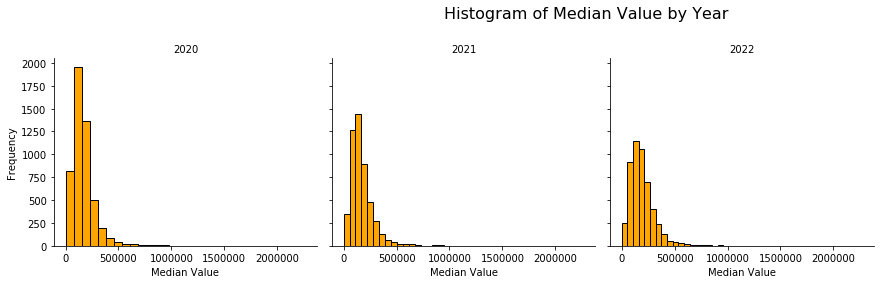

In [53]:
# Create a facet grid with histograms
plt.figure(figsize=(14, 8))
g = sns.FacetGrid(df_normalized, col='year', col_wrap=4, height=4)
g.map(plt.hist, 'median_value', bins=30, color='orange', edgecolor='black')

# Set titles and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Median Value', 'Frequency')
g.fig.suptitle('Histogram of Median Value by Year', fontsize=16)
g.fig.subplots_adjust(top=0.8)  # Adjust title to fit

plt.show()

In [54]:
# Assuming df_missing has both geo_id and year columns
# Create a set of unique combinations of geo_id and year
geo_year_combinations = df_missing[['geo_id', 'year']].drop_duplicates()

# Filter merged_df based on these combinations
filtered_merged_df = df_normalized.merge(geo_year_combinations, on=['geo_id', 'year'], how='inner')


In [55]:
print(filtered_merged_df.shape)
filtered_merged_df.head()

(1066, 34)


,geo_id,county,median_value,year,block_group,census_tract,counties,state,estimate_total_less_than_10000,estimate_total_10000_to_14999,...,estimate_total_175000_to_199999,estimate_total_200000_to_249999,estimate_total_250000_to_299999,estimate_total_300000_to_399999,estimate_total_400000_to_499999,estimate_total_500000_to_749999,estimate_total_750000_to_999999,estimate_total_1000000_to_1499999,estimate_total_1500000_to_1999999,estimate_total_2000000_or_more
0,1500000US290019505012,Adair County,50569.0,2020,Block Group 2,Census Tract 9505.01,Adair County,Missouri,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
1,1500000US290019509003,Adair County,0.0,2020,Block Group 3,Census Tract 9509,Adair County,Missouri,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2,1500000US290019510001,Adair County,0.0,2020,Block Group 1,Census Tract 9510,Adair County,Missouri,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
3,1500000US290099601011,Barry County,109507.0,2020,Block Group 1,Census Tract 9601.01,Barry County,Missouri,0.04,0.21,...,0.04,0.12,0.00,0.00,0.04,0.0,0.0,0.0,0.0,0.0
4,1500000US290099601022,Barry County,59557.0,2020,Block Group 2,Census Tract 9601.02,Barry County,Missouri,0.07,0.00,...,0.00,0.09,0.09,0.04,0.00,0.0,0.0,0.0,0.0,0.0


<Figure size 1008x576 with 0 Axes>

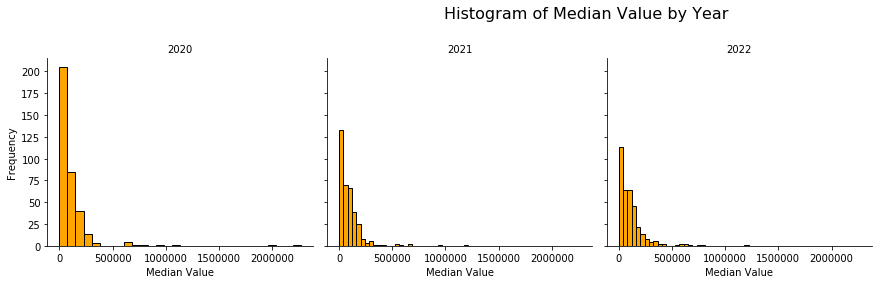

In [56]:
# Create a facet grid with histograms
plt.figure(figsize=(14, 8))
g = sns.FacetGrid(filtered_merged_df, col='year', col_wrap=4, height=4)
g.map(plt.hist, 'median_value', bins=30, color='orange', edgecolor='black')

# Set titles and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Median Value', 'Frequency')
g.fig.suptitle('Histogram of Median Value by Year', fontsize=16)
g.fig.subplots_adjust(top=0.8)  # Adjust title to fit

plt.show()

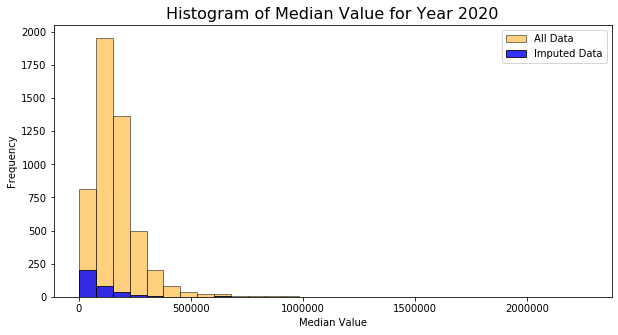

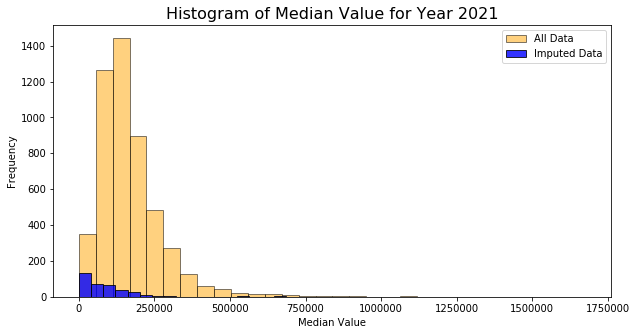

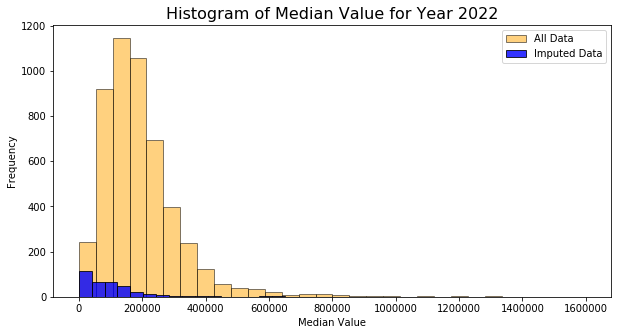

In [57]:
# Get unique years from the merged_df
unique_years = df_normalized['year'].unique()

# Create a figure for each year
for year in unique_years:
    plt.figure(figsize=(10, 5))
    
    # Filter the data for the current year
    year_data = df_normalized[df_normalized['year'] == year]
    filtered_year_data = filtered_merged_df[filtered_merged_df['year'] == year]

    # Plot histogram for merged_df with transparency
    plt.hist(year_data['median_value'], bins=30, color='orange', edgecolor='black', alpha=0.5, label='All Data')

    # Plot histogram for filtered_merged_df without transparency
    plt.hist(filtered_year_data['median_value'], bins=30, color='blue', edgecolor='black', alpha=0.8, label='Imputed Data')

    # Set titles and labels
    plt.title(f'Histogram of Median Value for Year {year}', fontsize=16)
    plt.xlabel('Median Value')
    plt.ylabel('Frequency')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

In [58]:
# Replace 'year_column_name' with the actual name of your year column
year_column_name = 'year'  # Example column name
years = df_normalized[year_column_name].unique()

# Get descriptive statistics for each year
for year in years:
    print(f"Descriptive statistics for {year}:")
    print(df_normalized[df_normalized[year_column_name] == year].describe())
    print("\n")

Descriptive statistics for 2020:
       median_value    year  estimate_total_less_than_10000  \
count  5.031000e+03  5031.0                     5031.000000   
mean   1.621172e+05  2020.0                        0.017507   
std    1.178473e+05     0.0                        0.053546   
min    0.000000e+00  2020.0                        0.000000   
25%    9.170750e+04  2020.0                        0.000000   
50%    1.400000e+05  2020.0                        0.000000   
75%    1.975500e+05  2020.0                        0.010000   
max    2.265809e+06  2020.0                        1.000000   

       estimate_total_10000_to_14999  estimate_total_15000_to_19999  \
count                    5031.000000                    5031.000000   
mean                        0.010976                       0.010626   
std                         0.035669                       0.041019   
min                         0.000000                       0.000000   
25%                         0.000000        

In [62]:
df_filled.dtypes

geo_id           object
block_group      object
census_tract     object
county           object
state            object
median_value    float64
year              int64
dtype: object

In [66]:
# Load df_filled as Imputed Median Value
imputed_median_house_value = df_filled.copy()

In [67]:
imputed_median_house_value.head()

,geo_id,block_group,census_tract,county,state,median_value,year
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,142300.0,2020
1,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,148300.0,2020
2,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,86100.0,2020
3,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,75300.0,2020
4,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,92300.0,2020


In [69]:
import psycopg2
from psycopg2 import sql
from psycopg2.extensions import adapt, register_adapter, AsIs
from sqlalchemy import create_engine,text
import getpass

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [70]:
#Create Table
mypasswd = getpass.getpass("Enter your database password: ")

Enter your database password: ········


In [ ]:
# Database connection details
database = "f24t03"
user = "jsmm8"
password = mypasswd
host = "pgsql"

# Create a connection to the database using SQLAlchemy for easier inserts
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}/{database}')

# Connect and create/drop the table, then insert data in chunks
try:
    # Connect to the database
    conn = psycopg2.connect(database=database, user=user, host=host, password=password)
    cursor = conn.cursor()
    print("Connected to the database.")

    # Drop the ethnicity table if it exists
    cursor.execute("DROP TABLE IF EXISTS imputed_median_house_value;")
    print("Dropped the imputed_median_house_value table if it existed.")

    # Create the <Table Name> table
    create_table_query = """
    CREATE TABLE imputed_median_house_value (
    geo_id VARCHAR(255),
    block_group VARCHAR(255),
    census_tract VARCHAR(255),
    county VARCHAR(255),
    state VARCHAR(255),
    median_value INT,
    year INT,
    PRIMARY KEY (geo_id, year)
    );
        """
    cursor.execute(create_table_query)
    conn.commit()
    print("Created the imputed_median_house_value table.")

    # Insert data from <dataframe> in chunks
    chunk_size = 500
    for start in range(0, len(imputed_median_house_value), chunk_size):
        chunk = imputed_median_house_value.iloc[start:start + chunk_size]
        chunk.to_sql('imputed_median_house_value', engine, if_exists='append', index=False)
        print(f"Uploaded a chunk of {len(chunk)} records to the imputed_median_house_value table.")

    print("Data uploaded successfully.")

    # Query the inserted data to confirm
    query = "SELECT * FROM imputed_median_house_value;"
    imputed_median_house_value = pd.read_sql(query, conn)
    print("Data extracted successfully! DataFrame shape:", imputed_median_house_value.shape)

except Exception as e:
    print("An error occurred:", e)

finally:
    # Ensure that the cursor and connection are closed
    if cursor:
        cursor.close()
    if conn:
        conn.close()

Connected to the database.
Dropped the imputed_median_house_value table if it existed.
Created the imputed_median_house_value table.
Uploaded a chunk of 500 records to the imputed_median_house_value table.
Uploaded a chunk of 500 records to the imputed_median_house_value table.
Uploaded a chunk of 500 records to the imputed_median_house_value table.
Uploaded a chunk of 500 records to the imputed_median_house_value table.
Uploaded a chunk of 500 records to the imputed_median_house_value table.
Uploaded a chunk of 500 records to the imputed_median_house_value table.
Uploaded a chunk of 500 records to the imputed_median_house_value table.
Uploaded a chunk of 500 records to the imputed_median_house_value table.
Uploaded a chunk of 500 records to the imputed_median_house_value table.
Uploaded a chunk of 500 records to the imputed_median_house_value table.
Uploaded a chunk of 500 records to the imputed_median_house_value table.
Uploaded a chunk of 500 records to the imputed_median_house_valu

In [ ]:
# SQL query to grant privileges
grant_privileges_query = "GRANT ALL PRIVILEGES ON TABLE imputed_median_house_value TO ypd5yb, jsmm8, remcmf, jsmm8;"

with engine.connect() as connection:
        connection.execute(text(grant_privileges_query))
        print("Privileges granted successfully.")

Privileges granted successfully.
